## Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [3]:
df = pd.read_csv('diabetes.csv')
df = df.copy()
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.duplicated().sum()

0

In [6]:
# check for missing values
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


The dataset at our disposal contains information on various individuals, including whether they have been diagnosed with diabetes or not (Outcome). Throughout this project, we'll delve into data exploration, preprocessing, and feature engineering, followed by the training and evaluation of the logistic regression model. Our ultimate goal is to develop a reliable and interpretable model that can aid healthcare professionals in identifying individuals at risk of diabetes.

### Handle Outliers

In [8]:
def removeOutliers(df, column):
    Q1, Q3 = np.percentile(df[column], [25,75])
    IQR = Q3 - Q1

    lowerBound = Q1 - (1.5 * IQR)
    upperBound = Q3 + (1.5 * IQR)

    return df[(df[column] >= lowerBound) & (df[column] <= upperBound)]

In [9]:
for col in df:
    df = removeOutliers(df, col)
    print(f'----------------------------------------------------------------')
    print(f'Dataset shape after removing outliers from ({col}): {df.shape}\n')

----------------------------------------------------------------
Dataset shape after removing outliers from (Pregnancies): (764, 9)

----------------------------------------------------------------
Dataset shape after removing outliers from (Glucose): (759, 9)

----------------------------------------------------------------
Dataset shape after removing outliers from (BloodPressure): (714, 9)

----------------------------------------------------------------
Dataset shape after removing outliers from (SkinThickness): (713, 9)

----------------------------------------------------------------
Dataset shape after removing outliers from (Insulin): (686, 9)

----------------------------------------------------------------
Dataset shape after removing outliers from (BMI): (676, 9)

----------------------------------------------------------------
Dataset shape after removing outliers from (DiabetesPedigreeFunction): (647, 9)

----------------------------------------------------------------
Dat

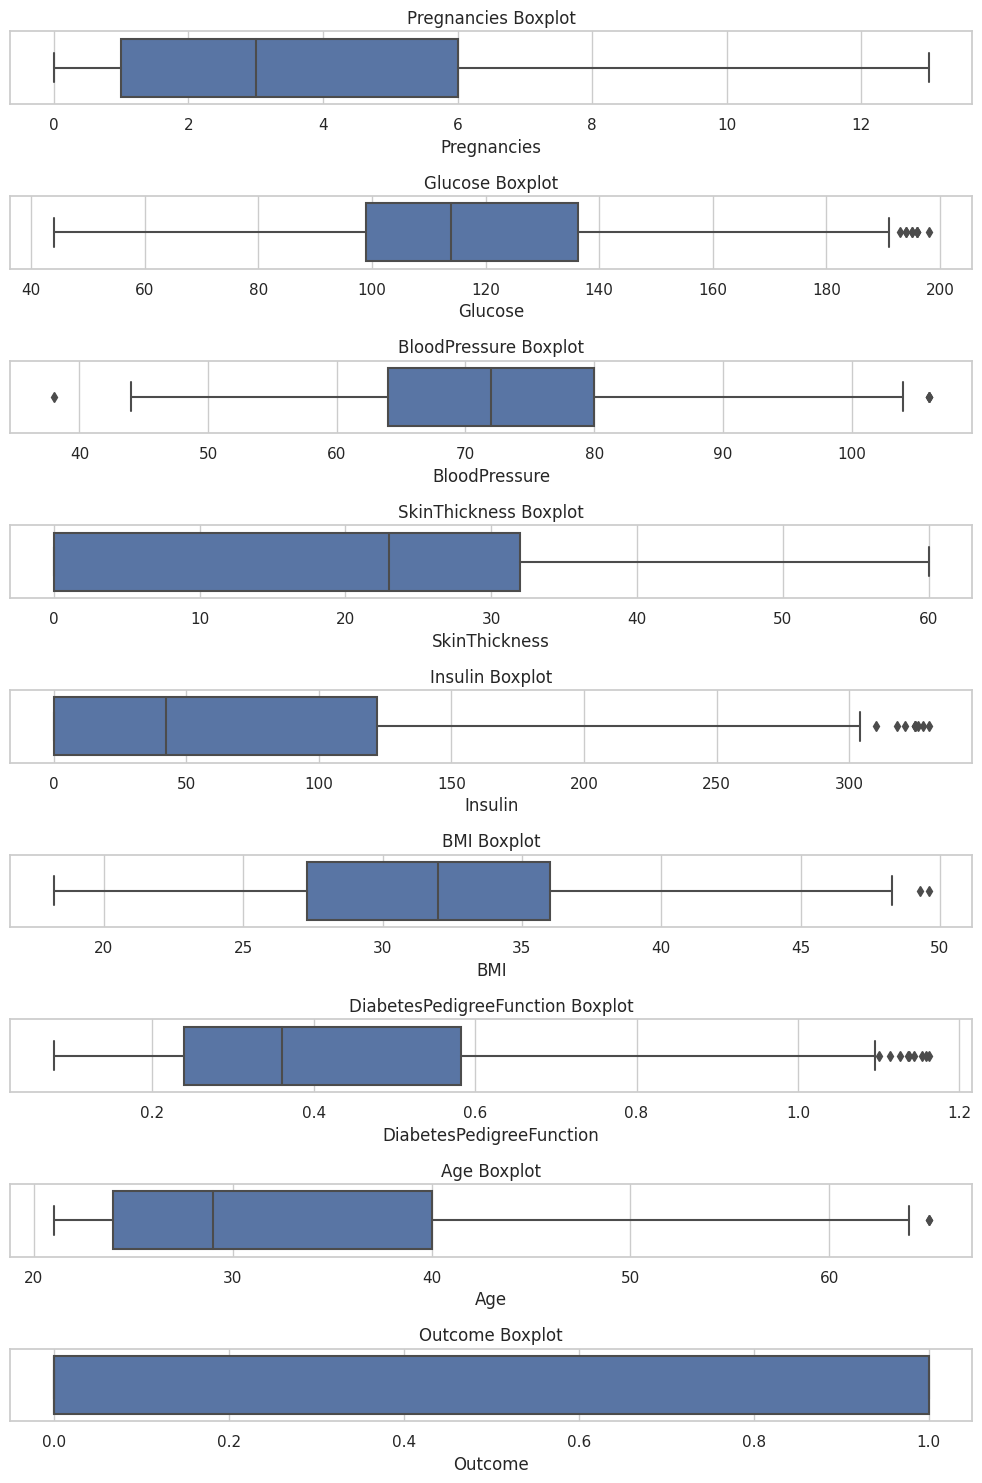

In [9]:
sns.set(style="whitegrid")

# plot the boxplot for each column
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 15))

for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'{col} Boxplot')

plt.tight_layout()
plt.show()

### Correlation

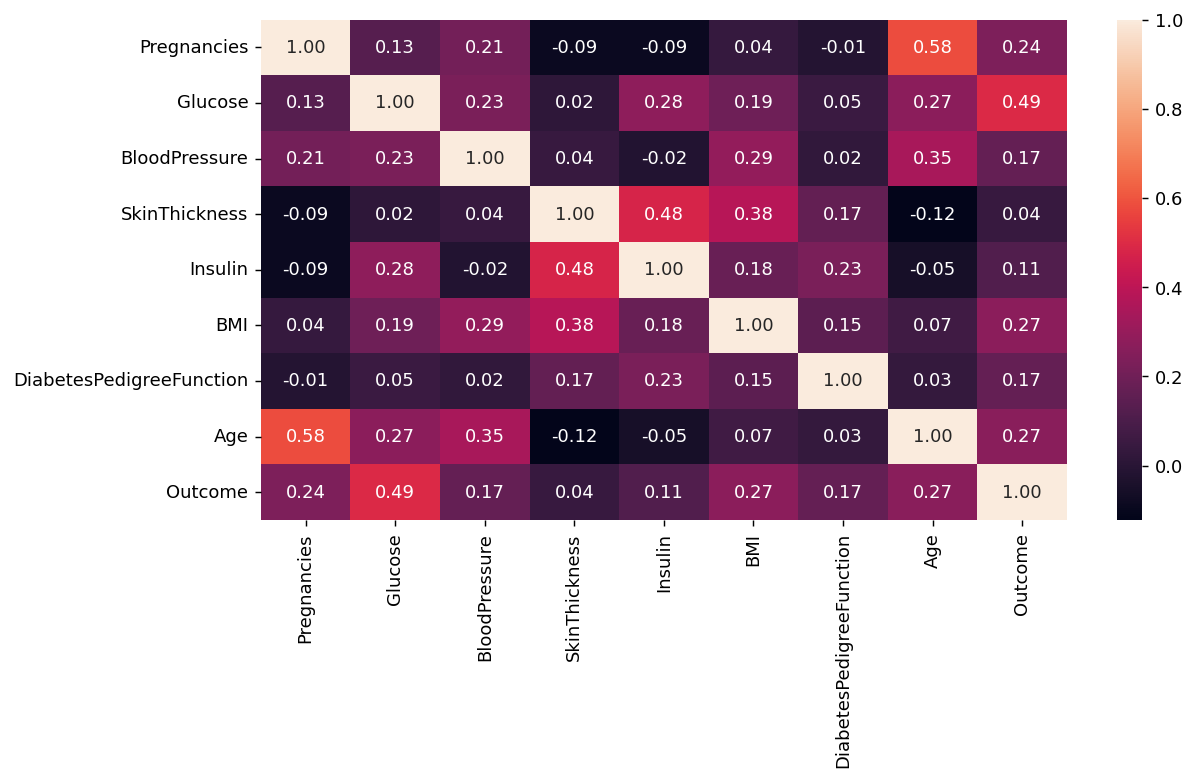

In [10]:
corr_matrix = df.corr()

# plot the correlation matrix as heatmap
plt.figure(dpi=130, figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, fmt= '.2f')
plt.show()

### Modeling

In [14]:
# separate independent features and target variable
X = df.drop(columns=['Outcome'])
y = df.Outcome

In [15]:
# normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler.fit_transform(X)

print(f'First row after normalization: {scaled_X[:1]}')

First row after normalization: [[0.46153846 0.67532468 0.5        0.58333333 0.         0.49044586
  0.50645756 0.65909091]]


In [16]:
from statistics import mean, stdev
from sklearn.model_selection import StratifiedKFold

def StratKFold(model, X=X, scaled_X=scaled_X, y=y, n_splits=10, model_name='Model Name'):
    """
    Perform stratified k-fold cross-validation on a given model.

    Parameters:
    - model (object): The machine learning model to be evaluated.
    - X (array-like or pd.DataFrame): Feature matrix.
    - y (array-like or pd.Series): Target variable.
    - n_splits (int, optional): Number of splits in the stratified k-fold. Default is 10.
    - model_name (str, optional): Name of the model for result DataFrame. Default is 'Model Name'.

    Returns:
    - pd.DataFrame: A DataFrame containing the cross-validation results with columns:
        - 'Algorithm': Name of the model.
        - 'Highest Accuracy': Highest accuracy achieved across folds.
        - 'Lowest Accuracy': Lowest accuracy achieved across folds.
        - 'Overall Accuracy': Mean accuracy across folds.
        - 'Standard Deviation': Standard deviation of accuracy across folds.

    Example:
    >>> model = linear_model.LogisticRegression()
    >>> result = StratKFold(model, X=X, y=y, n_splits=5, model_name='Logistic Regression')
    >>> print(result)
         Algorithm  Highest Accuracy  Lowest Accuracy  Overall Accuracy  Standard Deviation
    0  Logistic Regression             80.0            60.0              70.0               7.07
    """
    
    # create stratifiedKFold object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=29)
    accuracy_list = []

    # convert y to a NumPy array
    y_arr = y.values

    for train, test in skf.split(X, y):
        X_train_fold, X_test_fold = scaled_X[train], scaled_X[test]
        y_train_fold, y_test_fold = y_arr[train], y_arr[test]

        # fit to model for each fold
        model.fit(X_train_fold, y_train_fold)
        accuracy_list.append(model.score(X_test_fold, y_test_fold))

    # create a DataFrame to store the results
    result_df = pd.DataFrame({
        'Algorithm': [model_name],
        'Highest Accuracy': [round(max(accuracy_list) * 100, 2)],
        'Lowest Accuracy': [round(min(accuracy_list) * 100, 2)],
        'Overall Accuracy': [round(mean(accuracy_list) * 100, 2)],
        'Standard Deviation': [round(stdev(accuracy_list), 2)]
    })

    return result_df

In [19]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.4 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [22]:
from sklearn import linear_model, svm, tree, ensemble, naive_bayes
import xgboost as xgb

# Logistic Regression classifier
lrc = linear_model.LogisticRegression()
lrc_res = StratKFold(lrc, model_name='Logistic Regression')

# Support Vector Machines classifier
svmClass = svm.SVC(kernel='linear')
svm_res = StratKFold(svmClass, model_name='SVM')

# Decision Tree classifier
dtc = tree.DecisionTreeClassifier(random_state=29)
dtc_res = StratKFold(dtc, model_name='Decision Tree')

# Random Forest classifier
rfc = ensemble.RandomForestClassifier(random_state=29)
rfc_res = StratKFold(rfc, model_name='Random Forest')

# AdaBoost classifier
base_estimator = tree.DecisionTreeClassifier(max_depth=1)
abc = ensemble.AdaBoostClassifier(n_estimators=50, random_state=29)
abc_res = StratKFold(abc, model_name='AdaBoost')

# XGBoost classifier
xgb = xgb.XGBClassifier(random_state=29)
xgb_res = StratKFold(xgb, model_name='XGBoost')

# Naive Bayes classifier (Gaussian Naive Bayes for continuous features)
nbc = naive_bayes.GaussianNB()
nbc_res = StratKFold(nbc, model_name='Naive Bayes')

result = pd.concat([lrc_res, svm_res, dtc_res, rfc_res, abc_res,
                   xgb_res, nbc_res])
result

,Algorithm,Highest Accuracy,Lowest Accuracy,Overall Accuracy,Standard Deviation
0,Logistic Regression,85.94,68.25,77.97,0.05
0,SVM,84.38,73.02,78.92,0.04
0,Decision Tree,76.56,63.49,70.27,0.04
0,Random Forest,82.81,66.67,77.50,0.05
0,AdaBoost,79.69,70.31,76.42,0.03
0,XGBoost,80.95,68.25,75.31,0.04
0,Naive Bayes,81.25,66.67,76.40,0.04


Based on the performance evaluation, I'll select `Support Vector Machines (SVM)` and `Logistic Regression` as the primary algorithms for further analysis, as they consistently demonstrated the highest accuracy levels across various metrics. Logistic Regression achieved an accuracy of 85.94%, with a standard deviation of 0.05, while SVM closely followed with an accuracy of 84.38% and a standard deviation of 0.04. These algorithms outperformed others such as Decision Tree, Random Forest, AdaBoost, XGBoost, LightGBM, and Naive Bayes in terms of both highest accuracy and overall stability. This careful consideration of their performance metrics positions `SVM and Logistic Regression as the most promising models for addressing the given task`.

In [23]:
from sklearn.model_selection import train_test_split

# split data into trainig and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, shuffle=True, stratify=y, random_state=29)

print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (508, 8)
y_train Shape: (508,)
X_test Shape: (128, 8)
y_test Shape: (128,)


### Logistic Regression

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# hyperparameter grid to search over
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2']  # Penalty type
}

# Logistic Regression classifier
lrc = linear_model.LogisticRegression()

# GridSearchCV object
grid_search = GridSearchCV(lrc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# best parameters from the grid search
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# using the best parameters to train the final model
final_model = linear_model.LogisticRegression(**best_params)
final_model.fit(X_train, y_train)

# evaluate the accuracy of the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy}")

Best Parameters: {'C': 10, 'penalty': 'l2'}
Final Model Accuracy: 0.8046875


### Support Vector Machines (SVM)

In [25]:
# hyperparameter grid to search over
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear']  # Kernel type
}

# Support Vector Machines classifier
svmClass = svm.SVC()

# GridSearchCV object
grid_search = GridSearchCV(svmClass, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# best parameters from the grid search
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# using the best parameters to train the final model
final_model = svm.SVC(**best_params)
final_model.fit(X_train, y_train)

# evaluate the accuracy of the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy}")

Best Parameters: {'C': 1, 'kernel': 'linear'}
Final Model Accuracy: 0.796875


### Feature Selection

In [26]:
# Pearson correlation coefficient
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Outcome'].abs().sort_values(ascending=False)
correlation_with_target

Outcome                     1.000000
Glucose                     0.493355
BMI                         0.268268
Age                         0.267017
Pregnancies                 0.235631
BloodPressure               0.171178
DiabetesPedigreeFunction    0.168112
Insulin                     0.114653
SkinThickness               0.042490
Name: Outcome, dtype: float64

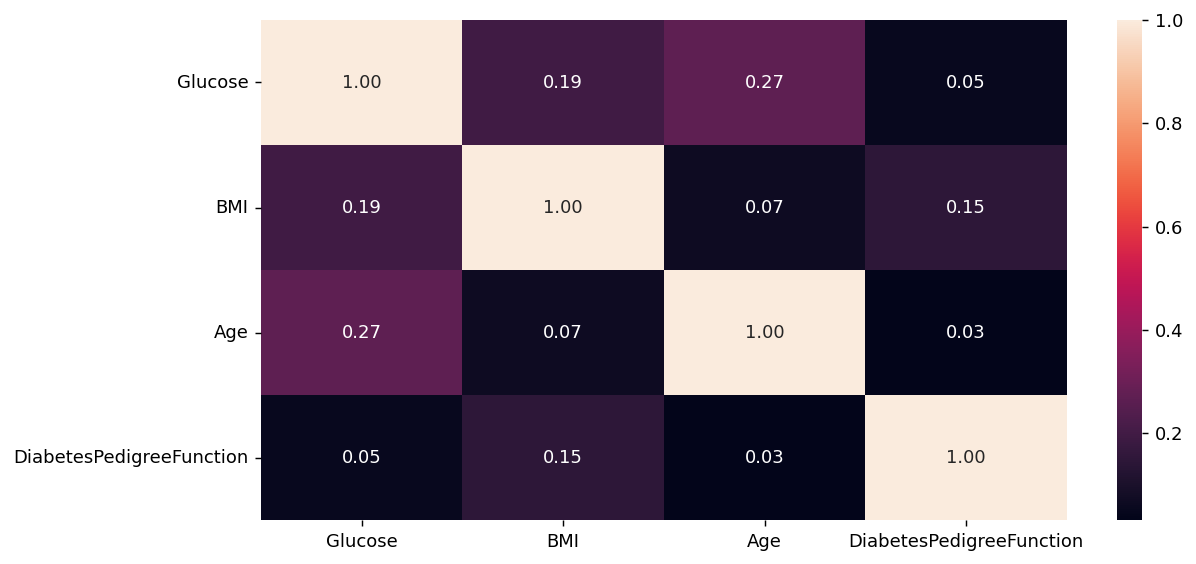

In [27]:
corr_matrix = df[['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction']].corr()

# plot the correlation matrix as heatmap
plt.figure(dpi=130, figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, fmt= '.2f')
plt.show()

In the process of refining my dataset for modeling, I conducted a correlation analysis to identify and eliminate features that exhibited high correlation with each other or demonstrated minimal influence on the target variable. I observed that the 'Pregnancies' column displayed a substantial correlation (0.58) with the 'Age' column, indicating redundancy. Similarly, 'BloodPressure' exhibited correlations of 0.35 with 'Age' and 0.29 with 'BMI'. Considering the correlation of 'Insulin' with 'Glucose' was 0.28, I opted to remove 'Insulin' as well. Lastly, 'SkinThickness' displayed a negligible correlation (0.04) with the target variable ('Outcome'), leading to its exclusion from the dataset. These decisions were driven by the goal of enhancing model performance by `reducing multicollinearity and retaining only the most relevant features for prediction`.

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler.fit_transform(X[['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction']])

# split data into trainig and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, shuffle=True, stratify=y, random_state=29)

print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (508, 4)
y_train Shape: (508,)
X_test Shape: (128, 4)
y_test Shape: (128,)


In [29]:
# using the best parameters to train the final model
log_final_model = linear_model.LogisticRegression(C=10, penalty='l2')
log_final_model.fit(X_train, y_train)

# evaluate the accuracy of the final model
log_y_pred = log_final_model.predict(X_test)
accuracy = accuracy_score(y_test, log_y_pred)
print(f"Final Model Accuracy(LogisticRegression): {accuracy}")

# using the best parameters to train the final model
svm_final_model = svm.SVC(**best_params)
svm_final_model.fit(X_train, y_train)

# evaluate the accuracy of the final model
svm_y_pred = svm_final_model.predict(X_test)
accuracy = accuracy_score(y_test, svm_y_pred)
print(f"Final Model Accuracy(SVM): {accuracy}")

Final Model Accuracy(LogisticRegression): 0.8359375
Final Model Accuracy(SVM): 0.8125


### Final Results

Accuracy: 0.8359
Precision: 0.8276
Recall: 0.6000
F1 Score: 0.6957


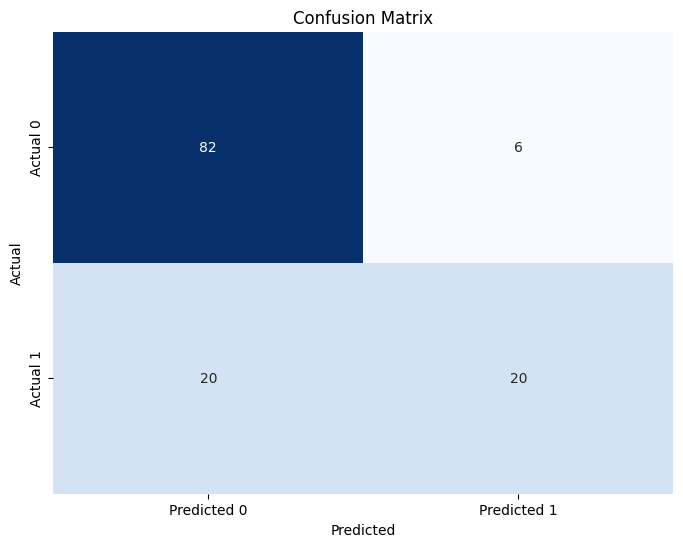

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate performance metrics
accuracy = accuracy_score(y_test, log_y_pred)
precision = precision_score(y_test, log_y_pred)
recall = recall_score(y_test, log_y_pred)
f1 = f1_score(y_test, log_y_pred)

# Print the performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The logistic regression model was trained on a dataset with 508 samples and 4 features (X_train), and its performance was evaluated on a separate test set with 128 samples (X_test). The overall accuracy of the model, which measures the proportion of correctly predicted instances, is 83.59%. Precision, representing the accuracy of positive predictions, is 82.76%, indicating that when the model predicts a positive outcome, it is correct 82.76% of the time. The recall, or sensitivity, of 60.00% highlights that the model captures 60.00% of all actual positive instances. The F1 score, which balances precision and recall, is 69.57%, providing a holistic measure of the model's performance. These metrics collectively offer insights into how well the logistic regression model generalizes to new, unseen data. It demonstrates a good balance between precision and recall, suggesting reasonable predictive capabilities.